In [11]:
import importlib
import os, pandas as pd, numpy as np
from joblib import dump, load
import sys
sys.path.append(os.path.dirname(os.path.dirname(os.getcwd())))
# from sod.core.evaluation import normalize
import sod.core.dataset as sod_core_dataset
importlib.reload(sod_core_dataset)
import sod.core.plot as sod_plot
importlib.reload(sod_plot)
# from sod.core.dataset import open_dataset # , normalize_df
# from sod import plot
isoutl = sod_core_dataset.is_outlier

dataframe = sod_core_dataset.open_dataset('allset.hdf', normalize=False, verbose=True)
print(sod_core_dataset.dfinfo(dataframe))

Opening /Users/riccardo/work/gfz/projects/sources/python/sod/sod/datasets/allset.hdf


ok (1451765 instances)
                         Min      Median           Max    #NAs  #<1Perc.  #>99Perc.
psd@0.05sec     -3076.526611 -121.268117    -18.616519  614002         0       8378
psd@0.1sec      -3076.526611 -123.085388    -18.540183       0     14518      14518
psd@0.2sec      -3076.526611 -124.808643    -18.394193       1     14518      14518
psd@0.5sec      -3076.526611 -126.766839    -17.799973       4     14518      14518
psd@1sec        -3076.526611 -124.398356    -17.364621      10     14518      14518
psd@2sec        -3076.526611 -121.330894    -14.675753      21     14518      14518
psd@3sec        -3076.526611 -121.021820     -7.249915      54     14518      14518
psd@5sec        -3076.526611 -122.757093      7.845090      56     14518      14518
psd@9sec        -3076.526611 -131.116604     19.164349   27289     14245      14245
amplitude_ratio     0.000000    0.001165     36.62

artifacts on ok segments: 11511


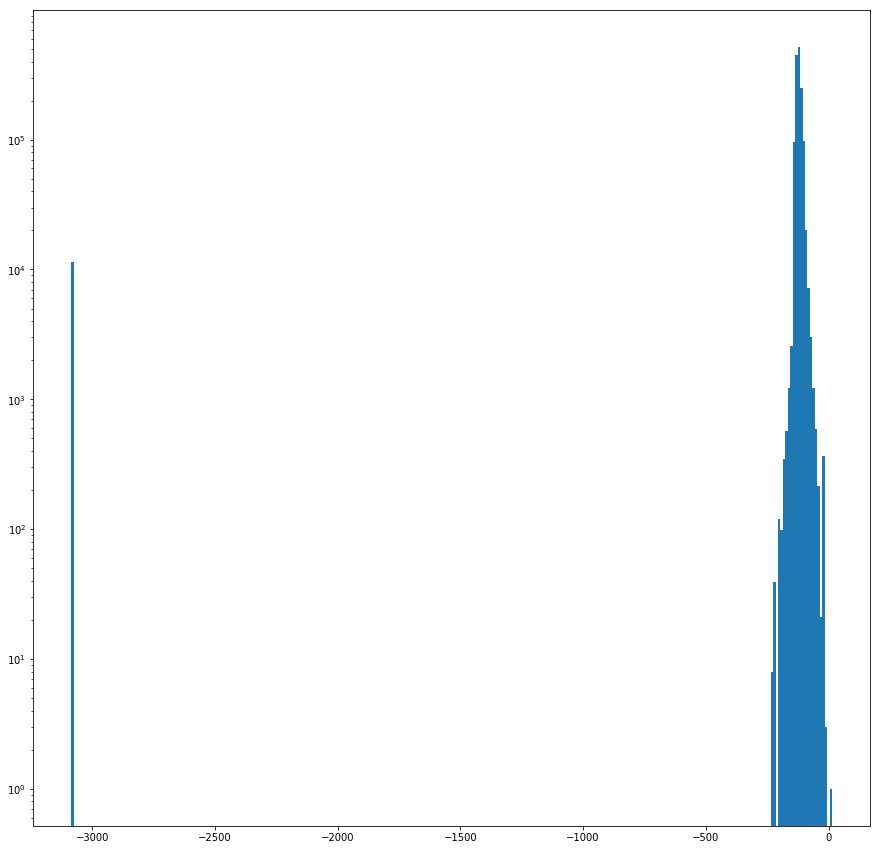

In [12]:
import importlib
import sod.core.plot as sod_plot
importlib.reload(sod_plot)
import sod.core.dataset as sod_dataset
importlib.reload(sod_dataset)
import matplotlib.pyplot as plt
import numpy as np

# matplotlib stuff (used below) =====================================
import matplotlib.pyplot as plt
from contextlib import contextmanager
@contextmanager
def plotparams(params):
    '''makes temporarily matplotlib params.
    Make sure to run this after %matplotlib inline.
    For info see https://stackoverflow.com/questions/36367986/how-to-make-inline-plots-in-jupyter-notebook-larger'''
    def_params = {k: plt.rcParams[k] for k in params}
    for k, v in params.items():
        plt.rcParams[k] = v
    try:
        yield
    finally:
        for k, v in def_params.items():
            plt.rcParams[k] = v

# =====================================================================

dinfo = sod_dataset.dataset_info(dataframe)

dataframe_ok = dataframe[dinfo.class_selector[dinfo.classnames[0]](dataframe)]

%matplotlib inline
col = dataframe_ok['psd@5sec']
print('artifacts on ok segments: %d' % len(dataframe_ok[col<-3000]))

# This prints the artifacts. Uncomment if you want to show them.
# We inspected them and they are issued from a miniSeed with all constant (relatively high)
# values. WHAT IS THE CAUSE?
# dataframe_ok = dataframe[dinfo.class_selector[dinfo.classnames[0]](dataframe)]
# dataframe_artifacts = dataframe_ok[col < -3000]
# for (staid, did, segid), _ in dataframe_artifacts.groupby(['station_id', 'dataset_id', 'allset.id']):
#     print('dataset id: %d, station id: %d, segment id: %d' % (did, staid, segid))
    

bins = np.arange(int(np.nanmin(col)-10), int(np.nanmax(col)+10), 10)
    
with plotparams({'figure.figsize': (15, 15)}):
    plt.hist(dataframe_ok['psd@5sec'], bins, log=True)
    plt.show()

In [13]:
print('Reading dataframe with pandas (no sod column renaming/conversions)')
dfr = pd.read_hdf('/Users/riccardo/work/gfz/projects/sources/python/sod/sod/datasets/allset.hdf')
o_dfr = dfr.copy()

Reading dataframe with pandas (no sod column renaming/conversions)


In [14]:
# now, mark the artifacts as outliers:

# first read the dataframe "normally":
import pandas as pd

is_inlier = dinfo.class_selector[dinfo.classnames[0]]

ok_artifacts = ((dfr['psd@5sec'] < - 500) | (dfr['psd@5sec'] > 500)) & is_inlier(dfr)
colval = 'a'
print('Re-setting labels for %d inliers actually artifacts. "window_type" column will be set to "%s"' %
      (ok_artifacts.sum(), colval))
dfr.loc[ok_artifacts, 'outlier'] = True
# we might set subclass, but this way we have to redefine a new dataset with new class selectors
# and it would be incompatible with allset.hdf. Thus set window_type
dfr.loc[ok_artifacts, 'window_type'] = colval
# set also outlier=False to all unknown. In the code, 'unlabeled.' belongs to the same class
dfr.loc[dfr.subclass.str.contains('unlabeled.'), 'outlier'] = False

Re-setting labels for 11511 inliers actually artifacts. "window_type" column will be set to "a"


In [15]:
# Splitting train and test:
print('Splitting train and test')

allset_train = dfr[is_inlier(dfr)]
print('\nTrain (all inliers): %d segments' % len(allset_train))
print('Train has these combinations of [subclass, window_type, outlier] values:')
for _, df_ in allset_train.groupby(['dataset_id', 'subclass', 'window_type', 'outlier']):
    print(_)

allset_test = dfr[~is_inlier(dfr)]
print('\nTest (others): %d segments' % len(allset_test))
print('Test has these combinations of [subclass, window_type, outlier] values:')
for _, df_ in allset_test.groupby(['dataset_id', 'subclass', 'window_type', 'outlier']):
    print(_)

Splitting train and test

Train (all inliers): 1440254 segments
Train has these combinations of [subclass, window_type, outlier] values:
(1, '', 'n', False)
(1, '', 's', False)
(2, '', '', False)
(3, '', '', False)

Test (others): 2903895 segments
Test has these combinations of [subclass, window_type, outlier] values:
(1, '', 'a', True)
(1, 'INVFILE:CH.GRIMS.2011-11-09T00:00:00.xml', 'n', True)
(1, 'INVFILE:CH.GRIMS.2011-11-09T00:00:00.xml', 's', True)
(1, 'INVFILE:CH.GRIMS.2015-10-30T10:50:00.xml', 'n', True)
(1, 'INVFILE:CH.GRIMS.2015-10-30T10:50:00.xml', 's', True)
(1, 'INVFILE:FR.PYLO.2010-01-17T10:00:00.xml', 'n', True)
(1, 'INVFILE:FR.PYLO.2010-01-17T10:00:00.xml', 's', True)
(1, 'INVFILE:SK.MODS.2004-03-17T00:00:00.xml', 'n', True)
(1, 'INVFILE:SK.MODS.2004-03-17T00:00:00.xml', 's', True)
(1, 'INVFILE:SK.ZST.2004-03-17T00:00:00.xml', 'n', True)
(1, 'INVFILE:SK.ZST.2004-03-17T00:00:00.xml', 's', True)
(2, '', '', True)
(2, '', 'a', True)
(2, 'unlabeled.maybe.outlier', '', False)


In [16]:
import pandas as pd

# Now we want to put some inlier in our test set. Let's add data inside the distribution to be sure we do not
# mark as inliers other artifacts:

print('Moving some inliers from training set to test set')
print()

print('Allset_train: %d instances' % len(allset_train))
print('Allset_test:  %d instances' % len(allset_test))
print()

percentage = 0.2  # this is the percentage of data to be put in the allset_test
min_len = int(0.5 + 1/percentage)

if min_len < 2:
    raise Exception('Change percentage!')

print()


cols = ['psd@0.2sec', 'psd@0.5sec', 'psd@1sec', 'psd@2sec', 'psd@5sec']
# Set the quantiles. Inliers will be taken when inside the quantiles defined below
# FOR ALL FEATURES in cols ABOVE: in order to put in test a number of inliers
# somehow equal to the outliers, [0.1, 0.9] is ok. Stricter ranges
quantile_l_th = 0.1
quantile_h_th = 1.0 - quantile_l_th
print('Adding some inlier to allset_test (inliers within [%.2f, %.2f] quantiles)' % (quantile_l_th, quantile_h_th))

trainings = []
tests = [allset_test]

for _, df_ in allset_train.groupby(['dataset_id', 'station_id', 'subclass', 'window_type']):
    df_train = df_
    len_df_ =len(df_)
    for colname in cols:
        df_col = df_[colname]
        df_ = df_[df_col.between(df_col.quantile(quantile_l_th), df_col.quantile(quantile_h_th), inclusive=False)]
        if df_.empty or len(df_) < min_len:
            break

    df_test = None if df_.empty else df_.sample(frac=percentage, random_state=1)
    if df_test is None or df_test.empty:
        print('Skipping dataframe (%d elements) identified by '
              '(dataset_id, station_id, subclass, window_type): %s' % (len_df_, str(_)))        
    else:
        tests.append(df_test)
        assert not len(set(df_test.index) - set(df_.index))
        df_train = df_train[~df_train.index.isin(df_test.index)]
    trainings.append(df_train)
    

allset_train =  pd.concat(trainings, sort=False, axis=0, copy=True).reset_index(drop=True, inplace=False)
allset_test =  pd.concat(tests, sort=False, axis=0, copy=True).reset_index(drop=True, inplace=False)

print()
print('Done. New dataset (compare numbers above, before this run):')
print('Allset_train: %d instances' % len(allset_train))
print('Allset_test: %d instances' % len(allset_test))

print()
print('DONE')

Moving some inliers from training set to test set

Allset_train: 1440254 instances
Allset_test:  2903895 instances


Adding some inlier to allset_test (inliers within [0.10, 0.90] quantiles)
Skipping dataframe (2 elements) identified by (dataset_id, station_id, subclass, window_type): (1, 681, '', 'n')
Skipping dataframe (2 elements) identified by (dataset_id, station_id, subclass, window_type): (1, 681, '', 's')
Skipping dataframe (1 elements) identified by (dataset_id, station_id, subclass, window_type): (1, 759, '', 'n')
Skipping dataframe (1 elements) identified by (dataset_id, station_id, subclass, window_type): (1, 759, '', 's')
Skipping dataframe (3 elements) identified by (dataset_id, station_id, subclass, window_type): (1, 964, '', 'n')
Skipping dataframe (3 elements) identified by (dataset_id, station_id, subclass, window_type): (1, 964, '', 's')
Skipping dataframe (2 elements) identified by (dataset_id, station_id, subclass, window_type): (1, 4167, '', 'n')
Skipping datafram

Printint distributions to check everything makes sense



Stats for dataset: train, class: ok, segments: 1295742


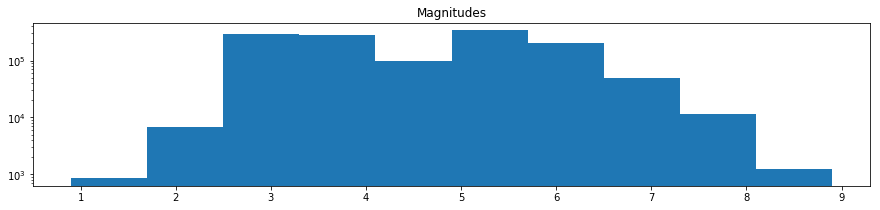

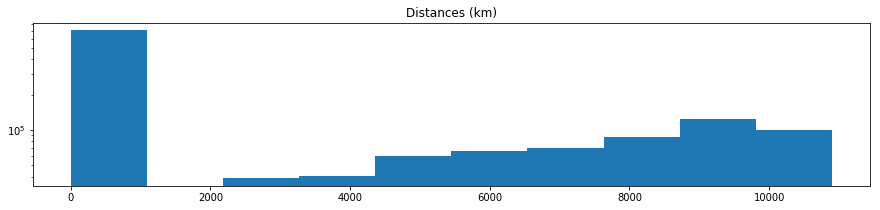


Stats for dataset: train, class: outl. (wrong inv), segments: 0

Stats for dataset: train, class: unlabeled (Me suspicious outl.), segments: 0

Stats for dataset: train, class: unlabeled (Me unknown), segments: 0


Stats for dataset: test, class: ok, segments: 93777


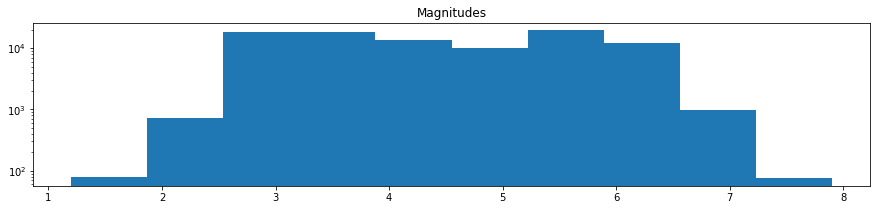

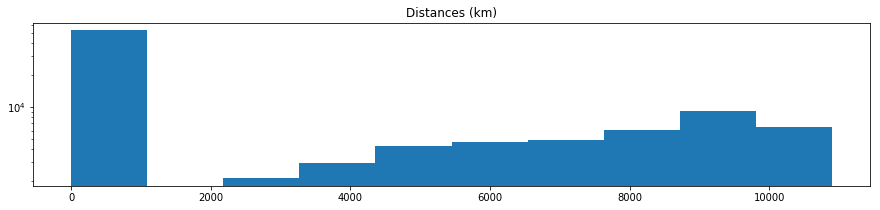


Stats for dataset: test, class: outl. (wrong inv), segments: 105075


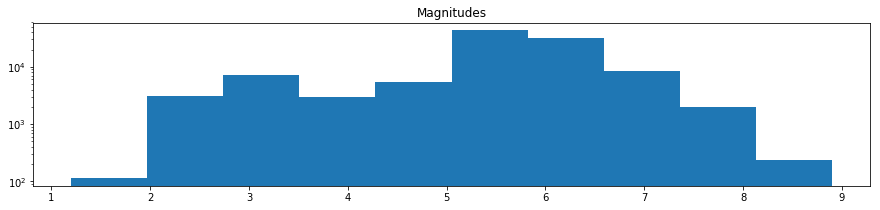

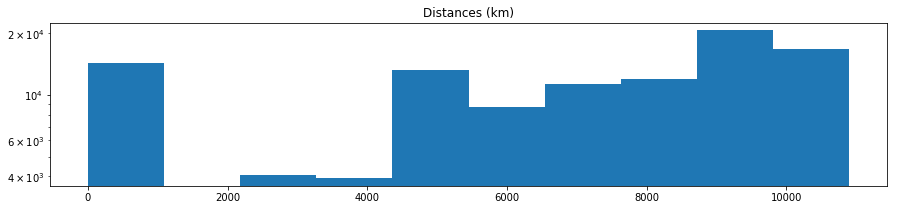


Stats for dataset: test, class: unlabeled (Me suspicious outl.), segments: 24437


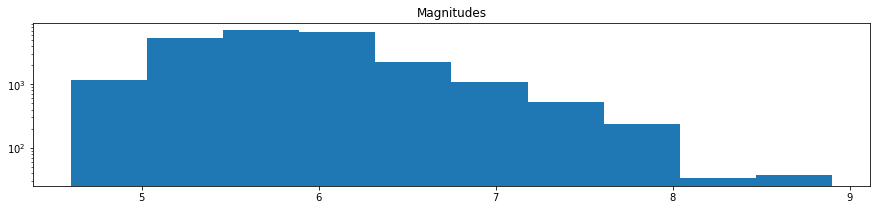

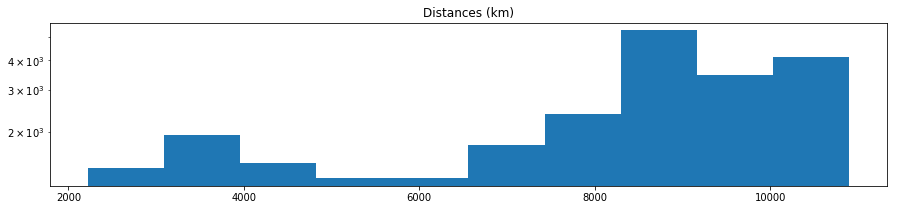


Stats for dataset: test, class: unlabeled (Me unknown), segments: 2774383


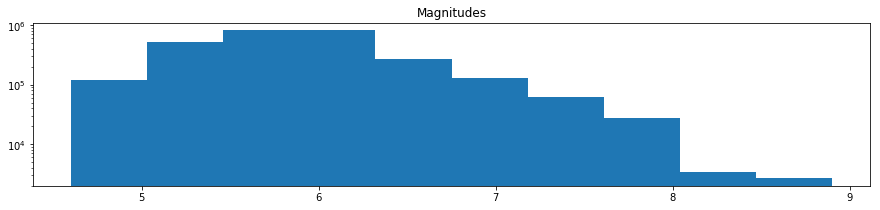

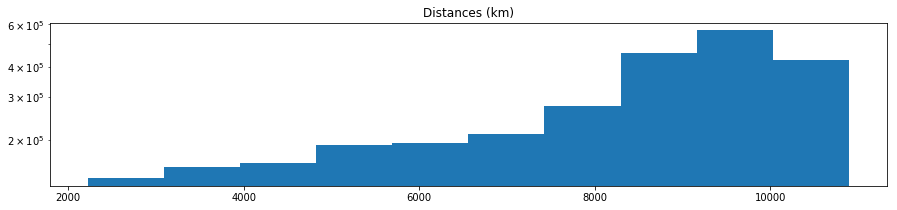

In [17]:
print('Printint distributions to check everything makes sense')
print()

for df_, name in [(allset_train, 'train'),  (allset_test, 'test')]:
    print()
    print('===================================================================')
    for cname in dinfo.classnames:
        tmpdf = df_[dinfo.class_selector[cname](df_)]
        print('\nStats for dataset: %s, class: %s, segments: %d' % (name, cname, len(tmpdf)))
        if tmpdf.empty:
            continue
        with plotparams({'figure.figsize': (15, 3)}):
            # print('Magnitude distributions')
            plt.hist(tmpdf.magnitude, histtype='bar', stacked=False, log=True)
            plt.title('Magnitudes')
            plt.show()
            # print('Distances (km) distributions')
            plt.hist(tmpdf.distance_km, histtype='bar', stacked=False, log=True)
            plt.title('Distances (km)')
            plt.show()
            
    

In [18]:
import os

path = '/Users/riccardo/work/gfz/projects/sources/python/sod/sod/datasets/'
assert os.path.isdir(path)

for df_, name in [(allset_train, 'allset_train'), (allset_test, 'allset_test')]:
    outpath = os.path.join(path, name + '.hdf')
    if os.path.isfile(outpath):
        print('File exist, this scripts does not override for security reasons. '
              'You need to manually delete the file %s' % outpath)
        break
    print('Saving to file %s' % outpath)
    df_.to_hdf(outpath, format='table', mode='w', key=name)

Saving to file /Users/riccardo/work/gfz/projects/sources/python/sod/sod/datasets/allset_train.hdf
Saving to file /Users/riccardo/work/gfz/projects/sources/python/sod/sod/datasets/allset_test.hdf
